# A Toy Model of Superposition

Theory: there are high level 'features' $x_i$ that the network learns about data. These are high-dimensional, and are encoded into neural networks in a low-dimensional manner through neurons. The thought is that all features $x_i$ can be represented in a sparse activation vector $x$. The sparsity of these features come from the intuitive fact that not every feature in real life would be represented for any token. We represent the projection of a feature $x$ to the neuron basis as $h = Wx$. 

Consider that $W \in \mathbb{R}^{n\times m}$ is a short, wide matrix. Here, $m$ is the (large) dimension of the feature space, and $n$ is the (comparatively small) dimension of the neuron space. Each row $W = [w_1^\top, \ldots, w_m^\top]^\top, w_i\in\mathbb{R^n}$ is a direction in the neuron basis corresponding to a specific feature.

# Data Creation

From Toy Models of Superposition: 
> The input vectors x are synthetic data intended to simulate the properties we believe the true underlying features of our task have. We consider each dimension $x_i$ to be a "feature". Each one has an associated sparsity $S_i$ and importance $I_i$. We let $x_i=0$ with probability $S_i$, but is otherwise uniformly distributed between $[0,1]$.The choice to have features distributed uniformly is arbitrary. An exponential or power law distribution would also be very natural. In practice, we focus on the case where all features have the same sparsity, $S_i = S$.

In [140]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass
import os

os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"   # for CUDA ≥11

@dataclass
class Config:
  tied: int
  linear: bool = True

config = Config(tied=1)

def create_data_sample(num_samples, batch_size, feature_dim, sparsities, distribution="uniform", device="cuda"):
    """
    Creates a sample of data with given parameters.
    
    Args:
        feature_dim (int): The number of features in x_i.
        batch_size (int): The number of samples in the batch.
        num_samples (int): The number of samples to generate, ie [num_samples, batch_size, feature_dim].
        sparsity (float): The fraction of non-zero elements in the data.
        distribution (str): The distribution to use for generating data. Currently only accepts 'uniform'.

    Returns:
        torch.Tensor: A tensor containing the generated data sample.
    """
    if distribution == "uniform":
        data = torch.rand((num_samples, batch_size, feature_dim), device=device).float()
    else:
        raise ValueError("Unsupported distribution type. Use 'uniform' or 'normal'.")
    
    # Apply sparsity
    mask = torch.rand(data.shape, device="cuda") < sparsities.view(-1, 1, 1)
    data[mask] = 0
    
    return data

In [141]:
from torch import nn
import einops
from einops import rearrange, reduce, repeat

class ToyModel(nn.Module):
    def __init__(self, num_models, feature_dim, neuron_dim, linear = False, tied = True, device="cuda"):
        super(ToyModel, self).__init__()
        
        # Linearly encode features without a bias
        self.W = nn.Parameter(torch.empty((feature_dim, neuron_dim), device=device))
        nn.init.xavier_normal_(self.W)
        self.bias_final = nn.Parameter(torch.zeros(feature_dim, device=device))

        self.neuron_dim = neuron_dim
        self.feature_dim = feature_dim
        self.linear = linear
        self.tied = tied
        self.num_models = num_models

        assert(tied == True)
        
    def forward(self, x):
        """
        x shape: (num_models, batch_size, feature_dim)
        returns: (num_models, batch_size, feature_dim)
        """
        
        # Encode the input
        encoded = torch.matmul(x, self.W)
        
        if self.tied:
            # Note: W is stored as W^T in the encoder
            decoded = torch.matmul(encoded, self.W.T)
            decoded += self.bias_final
        
        if not self.linear:
            # Apply a linear activation function
            decoded = torch.relu(decoded)

        return decoded


In [142]:
from torch import nn
import einops

class ToyModel(nn.Module):
    def __init__(self, num_models, feature_dim, neuron_dim, linear = False, tied = True, device="cuda"):
        super(ToyModel, self).__init__()
        
        # Linearly encode features without a bias
        self.W = nn.Parameter(torch.empty((num_models, feature_dim, neuron_dim), device=device))
        nn.init.xavier_normal_(self.W)
        self.bias_final = nn.Parameter(torch.zeros(num_models, feature_dim, device=device))

        self.neuron_dim = neuron_dim
        self.feature_dim = feature_dim
        self.linear = linear
        self.tied = tied
        self.num_models = num_models

        assert(tied == True)
        
    def forward(self, x):
        """
        x shape: (num_models, batch_size, feature_dim)
        returns: (num_models, batch_size, feature_dim)
        """
        
        # Encode the input
        # [num_models, batch_size, feature_dim] x [num_models, feature_dim, neuron_dim] -> [num_models, batch_size, neuron_dim]
        encoded = torch.einsum('mbf,mfn->mbn', x, self.W)
        
        if self.tied:
            # Note: W is stored as W^T in the encoder
            # [num_models, batch_size, neuron_dim] x [num_models, neuron_dim, feature_dim] -> [num_models, batch_size, feature_dim]
            decoded = torch.einsum('mbn,mnf->mbf', encoded, self.W.transpose(1,2))

            decoded += self.bias_final.unsqueeze(1)  # Add bias across batch dimension
        
        if not self.linear:
            # Apply a linear activation function
            decoded = torch.relu(decoded)

        return decoded


Beginning with feature dim=20; neuron dim = 5; $I_i=0.7^i$

In [165]:
def loss_with_importance(x, xhat, importances):
    """
    Computes the loss with importance weighting.
    
    Args:
        x (torch.Tensor): The original input data. shape [num_models, batch_size, feature_dim]
        xhat (torch.Tensor): The reconstructed data.
        importances (torch.Tensor): The importance weights for each feature. shape [num_models, feature_dim]
    
    Returns:
        torch.Tensor: The computed loss.
    """
    # Compute the loss
    loss = torch.mean(importances.unsqueeze(1) * (x - xhat) ** 2)
    
    return loss

In [169]:
I_i

tensor([[1.0000, 0.7000, 0.4900, 0.3430, 0.2401, 0.1681, 0.1176, 0.0824, 0.0576,
         0.0404, 0.0282, 0.0198, 0.0138, 0.0097, 0.0068, 0.0047, 0.0033, 0.0023,
         0.0016, 0.0011],
        [1.0000, 0.7000, 0.4900, 0.3430, 0.2401, 0.1681, 0.1176, 0.0824, 0.0576,
         0.0404, 0.0282, 0.0198, 0.0138, 0.0097, 0.0068, 0.0047, 0.0033, 0.0023,
         0.0016, 0.0011]], device='cuda:0')

In [188]:
from tqdm import tqdm


def train_model(ModelClass, importances, num_models, feature_dim, neuron_dim, batch_size, 
        sparsities, epochs = 10000, device="cuda", validate=False, linear=False, tied=True, lr=0.01, save_weights=False):
    
    toy_model = ModelClass(num_models=num_models, feature_dim=feature_dim, neuron_dim=neuron_dim, linear=config.linear, tied=config.tied, device="cuda")
    # toy_model = ModelClass(feature_dim=feature_dim, neuron_dim=neuron_dim, linear=linear, tied=tied, device=device)
    
    if validate:
        # Validation set
        data_val = create_data_sample(num_samples=num_models, feature_dim=feature_dim, batch_size=batch_size, sparsities=sparsities)
    # Define the optimizer
    optimizer = torch.optim.AdamW(toy_model.parameters(), lr=lr)

    losses = []
    val_losses = []
    weights_saved = []
    for epoch in tqdm(range(epochs)):
        # Create a sample data point
        data = create_data_sample(num_samples=num_models, feature_dim=feature_dim, batch_size=batch_size, sparsities=sparsities)
        # toy_model.zero_grad()
        optimizer.zero_grad()

        # Forward pass through the model
        output = toy_model(data)
        
        # Compute the loss (mean squared error)
        loss = loss_with_importance(data, output, importances)
        
        # Backward pass and optimization
        loss.backward()
        losses.append(loss.item())
        optimizer.step()    

        if validate:
            with torch.no_grad():
                val_output = toy_model(data_val)
                val_loss = loss_with_importance(data_val, val_output, importances)
                # print(f"Validation Loss: {val_loss.item():.4f}")
                # Store the loss for plotting
                val_losses.append(val_loss.item())
        if save_weights:
            weights_saved.append(toy_model.W.detach().cpu().numpy().copy())

    return toy_model, losses, val_losses, weights_saved

In [179]:
from matplotlib.colors import LinearSegmentedColormap

# ────────────────────────────────────────────────────────────────
#  WᵀW / cosine-similarity heat-map with background-at-zero
# ────────────────────────────────────────────────────────────────
def plot_WtW(
    model,
    layer_name : str  = "W",
    cosine     : bool = False,
    zero_eps   : float = 1e-5,       # |value| < zero_eps  →  bg colour
    figsize    : tuple = (3, 3),
    ax         = None,
    title      : str   | None = r"$\cos\theta_{ij}$",
    which_w = 0
):
    # 1 — extract weight matrix
    with torch.no_grad():
        W = getattr(model, layer_name).detach().cpu().numpy()   # (n, m)
        W = W[which_w]  # Select the specific weight matrix for the model
    # 2 — Gram matrix
    G = W @ W.T                                   # (m, m)
    if cosine:
        d = np.sqrt(np.diag(G)) + 1e-12
        G = G / np.outer(d, d)

    # 3 — mask (|G| < zero_eps) so they get background colour
    G_masked = np.ma.masked_where(np.abs(G) < zero_eps, G)

    # 4 — custom diverging colormap:  blue  →  bg  →  red
    #     bg colour comes from the Axes face colour (usually light-grey)
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    bg = ax.get_facecolor()[:3]      # RGBA → RGB

    cmap = LinearSegmentedColormap.from_list(
        "blue-bg-red",
        [
            (0.0, "blue"),   # –1
            (0.5, bg),       #  0
            (1.0, "red"),    # +1
        ],
        N=256,
    )

    # 5 — plot
    im = ax.imshow(
        G_masked,
        origin="lower",
        cmap=cmap,
        vmin=-1,
        vmax=1,
        interpolation="none",
    )
    ax.set_xlabel("Feature  j")
    ax.set_ylabel("Feature  i")
    ax.set_title(title)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    return ax

def plot_feature_superposition(
    model,
    layer_name: str   = "W",
    normalize_lengths: bool = True,
    normalize_colors: bool  = True,
    figsize: tuple    = (3, 5),
    title: str | None = "Feature Superposition",
    ax = None,
    which_w = 0
):
    """
    Bars: lengths ∝ ||W_i|| (optionally normalized to [0,1])
    Colors: ∝ S_i = sum_j (x_i · x_j)^2 (optionally normalized to [0,1])
    """
    # 1 — extract W: (n_features, dim)
    with torch.no_grad():
        W = getattr(model, layer_name).detach().cpu().numpy()
        W = W[which_w]  # Select the specific weight matrix for the model
        
    # 2 — compute feature norms and superposition scores
    norms = np.linalg.norm(W, axis=1)             # ||W_i||
    G = W @ W.T                                   # Gram matrix
    S = np.sum(G**2, axis=1)                      # superposition per feature

    # 3 — normalize if requested
    if normalize_lengths:
        norms_plot = (norms - norms.min()) / (np.ptp(norms) + 1e-12)
    else:
        norms_plot = norms

    if normalize_colors:
        S_plot = (S - S.min()) / (np.ptp(S) + 1e-12)
    else:
        S_plot = S

    # 4 — color map black→gold
    cmap = LinearSegmentedColormap.from_list(
        "black-gold",
        [(0.0, "black"), (1.0, "gold")],
        N=256,
    )
    colors = cmap(S_plot)

    # 5 — plot horizontal bars
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    idx = np.arange(len(norms_plot))[::-1]   # reverse for top-down
    ax.barh(idx, norms_plot[idx], color=colors[idx], edgecolor="none")
    ax.set_yticks(idx)
    ax.set_yticklabels([f"{i}" for i in idx])
    ax.invert_yaxis()
    ax.set_xlabel(normalize_lengths
                  and "Normalized ‖W_i‖"
                  or "‖W_i‖")
    ax.set_ylabel("Feature  i")
    if title:
        ax.set_title(title)
    plt.tight_layout()
    return ax


## Replicating the de-orthogonalization of feature representations as feature sparsity increases

The idea here is that, with increasing feature sparsity (and the benefit of a nonlinear activation function), the model is able to represent *more* features than the true dimension representable by its neuron space. This is done by representing features in a "nearly orthogonal" manner.

100%|██████████| 10000/10000 [00:07<00:00, 1281.62it/s]


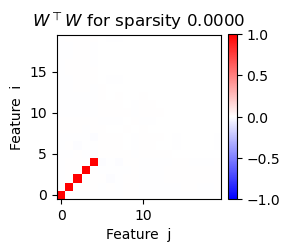

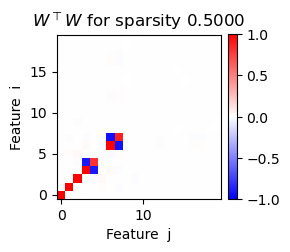

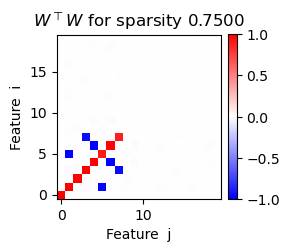

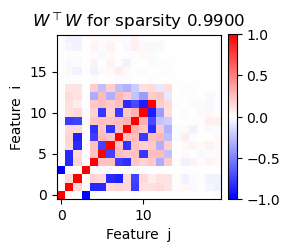

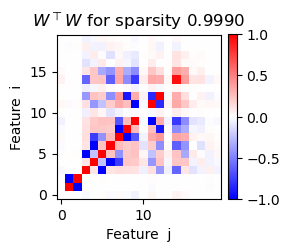

In [191]:
torch.use_deterministic_algorithms(False) # for reproducibility
feature_dim = 20
neuron_dim = 5
config.linear = False

sparsities = torch.tensor([0, 0.5, 0.75, 0.99, 0.999], device="cuda")
num_models = sparsities.shape[0]

importances = torch.tensor(0.75, device="cuda") ** torch.arange(0, feature_dim, device="cuda")
importances = repeat(importances, "f -> b f", b=num_models)

# Train the model
trained = train_model(ToyModel, importances, num_models, validate=False, epochs=10000, sparsities = sparsities, lr=0.01, 
linear=False, feature_dim=feature_dim, neuron_dim=neuron_dim, batch_size=batch_size)

model = trained[0]
for i in range(num_models):
    plot_WtW(model, which_w = i, cosine=False, title=f"$W^\\top W$ for sparsity {sparsities[i].item():.4f}", figsize=(3, 3))
    plt.show()

We see a similar effect when we crank up the feature scale

In [205]:
torch.use_deterministic_algorithms(False) # for reproducibility
feature_dim = 100
neuron_dim = 20
config.linear = False

sparsities = torch.tensor([0, 0.5, 0.75, 0.9, 0.99, 0.999], device="cuda")
num_models = sparsities.shape[0]

importances = torch.tensor(0.95, device="cuda") ** torch.arange(0, feature_dim, device="cuda")
importances = repeat(importances, "f -> b f", b=num_models)

# Train the model
trained = train_model(ToyModel, importances, num_models, validate=False, epochs=10000, sparsities = sparsities, lr=0.01, 
linear=False, feature_dim=feature_dim, neuron_dim=neuron_dim, batch_size=batch_size)

model = trained[0]
# for i in range(num_models):
#     plot_WtW(model, which_w = i, cosine=False, title=f"$W^\\top W$ for sparsity {sparsities[i].item():.4f}", figsize=(3, 3))
#     plt.show()

100%|██████████| 10000/10000 [00:08<00:00, 1219.30it/s]


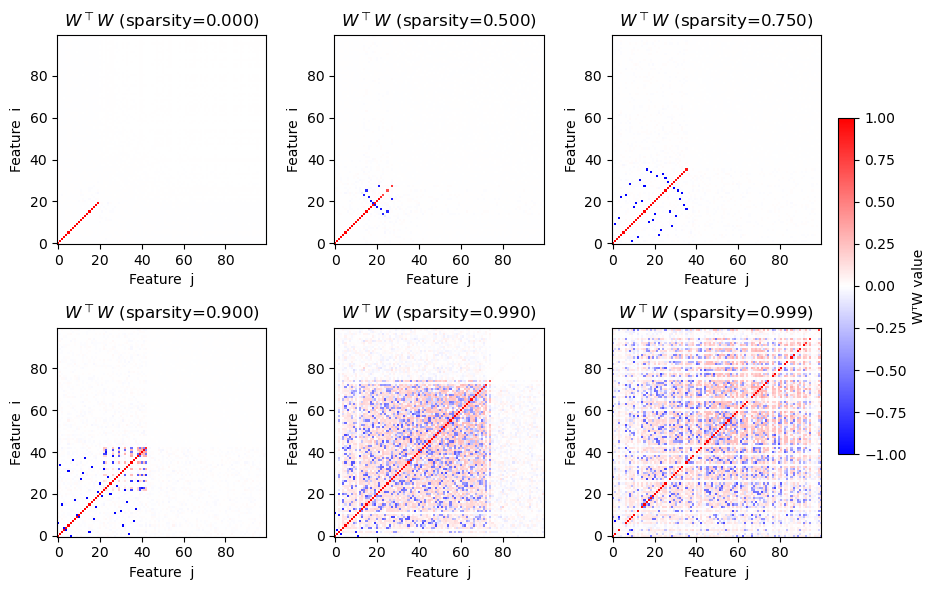

In [206]:
# Layout parameters
n_cols     = 3
n_rows     = (num_models + n_cols - 1) // n_cols
figsize    = (n_cols * 3, n_rows * 3)

# 1) Create the grid of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
axes_flat = axes.flatten()

# 2) Plot into each subplot, suppressing the internal colorbar
for i in range(num_models):
    ax = axes_flat[i]
    # Temporarily disable the built-in colorbar by monkey-patching plt.colorbar
    # (so it won't appear per-subplot)
    _orig_cb = plt.colorbar
    plt.colorbar = lambda *args, **kwargs: None

    # Call your function
    plot_WtW(
        model,
        which_w=i,
        cosine=False,
        title=f"$W^\\top W$ (sparsity={sparsities[i].item():.3f})",
        ax=ax,         # draw into our grid ax
        figsize=None,  # ignored when ax is supplied
    )

    # Restore the real colorbar
    plt.colorbar = _orig_cb

# 3) Remove unused axes
for j in range(num_models, len(axes_flat)):
    fig.delaxes(axes_flat[j])

# 4) Grab one of the AxesImages to use for the shared colorbar
#    (they all share the same colormap and vmin/vmax)
im = axes_flat[0].images[-1]

# 5) Add a single, global colorbar
cbar = fig.colorbar(im, ax=axes_flat[:num_models], fraction=0.02, pad=0.02)
cbar.set_label("WᵀW value")

# plt.tight_layout()
plt.show()

## Phase Change Plots

Now, lets sweep over various levels of sparsity and feature importance and create a phase change plot.

We want a grid of models where each model is defined by the sparsity level $(S)$ and importance tuple $(I_1, I_2)$. 

We want to fix the original importance $I_1 = 1$ and vary the second importance $I_2$ on interval $[0.1,10]$.

In [380]:
from itertools import product

def sweep_over_models(spasities_range, importances_range, num_sweep=300, space = "log"):
    num_models = num_sweep**2
    # Define importances vectors
    ones = torch.ones(num_sweep, device="cuda")
    if space == "log":
        importances = torch.logspace(importances_range[0], importances_range[1], num_sweep, device="cuda")
        # Define sparsities
        sparsities = torch.logspace(spasities_range[0], spasities_range[1], steps=num_sweep, device="cuda")
    elif space == "linear":
        importances = torch.linspace(importances_range[0], importances_range[1], num_sweep, device="cuda")
        # Define sparsities
        sparsities = torch.linspace(spasities_range[0], spasities_range[1], steps=num_sweep, device="cuda")
    else: 
        raise ValueError("space must be either 'log' or 'linear'")
    importances = torch.stack([ones, importances]).T

    
    # Repeat each sparsity for each importance vector (num_sweep times)
    sparsities = sparsities.repeat_interleave(num_sweep)  # Shape: [num_sweep^2]

    # Repeat the entire importances tensor num_sweep times
    importances = importances.repeat(num_sweep, 1)  # Shape: [num_sweep^2, 2]

    torch.use_deterministic_algorithms(False) # for reproducibility
    feature_dim = 2
    neuron_dim = 1
    config.linear = False

    num_models = sparsities.shape[0]

    # Train the model
    trained = train_model(ToyModel, importances, num_models, validate=False, epochs=1000, sparsities = sparsities, lr=0.01, 
    linear=False, feature_dim=feature_dim, neuron_dim=neuron_dim, batch_size=batch_size)

    model = trained[0]
    return model.W.detach().cpu().numpy(), sparsities.cpu().numpy(), importances.cpu().numpy()

Ws = []; sparsities=[]; importances = []

# Essentially batching squares of the 2D parameter space to fit on the gpu. Adjust these as needed to fit on yours and cover the entire domain.
sparsities_ranges = [
    [-1,-0.75],
    [-0.75,-0.5],
    [-0.5, -0.4],
    [-0.4, -0.3],
    [-0.3, -0.2],
    [-0.2, -0.1],    
    [-0.1, -0.075], 
    [-0.075, -0.05],
    [-0.05, -0.025],
    [-0.025, 0]
    ]
importances_ranges = [
    [-1,0],
    [0, 1]
]

for sparsities_range, importances_range in product(sparsities_ranges, importances_ranges):
    new_w, new_sparsities, new_importances = sweep_over_models(sparsities_range, importances_range, num_sweep=100)

    Ws.append(new_w)
    sparsities.append(new_sparsities)
    importances.append(new_importances)

Ws = np.concat(Ws, axis=0)
sparsities = np.concat(sparsities, axis=0)
importances = np.concat(importances, axis=0)

100%|██████████| 1000/1000 [00:05<00:00, 196.75it/s]


Looks like the figure is approaching that of the original paper!

(<Figure size 1000x800 with 1 Axes>,
 <Axes: title={'center': 'Sparsity-Relative Importance Phase Diagram (n=2, m=1)'}, xlabel='Relative Feature Importance', ylabel='Feature Density (1-S)'>)

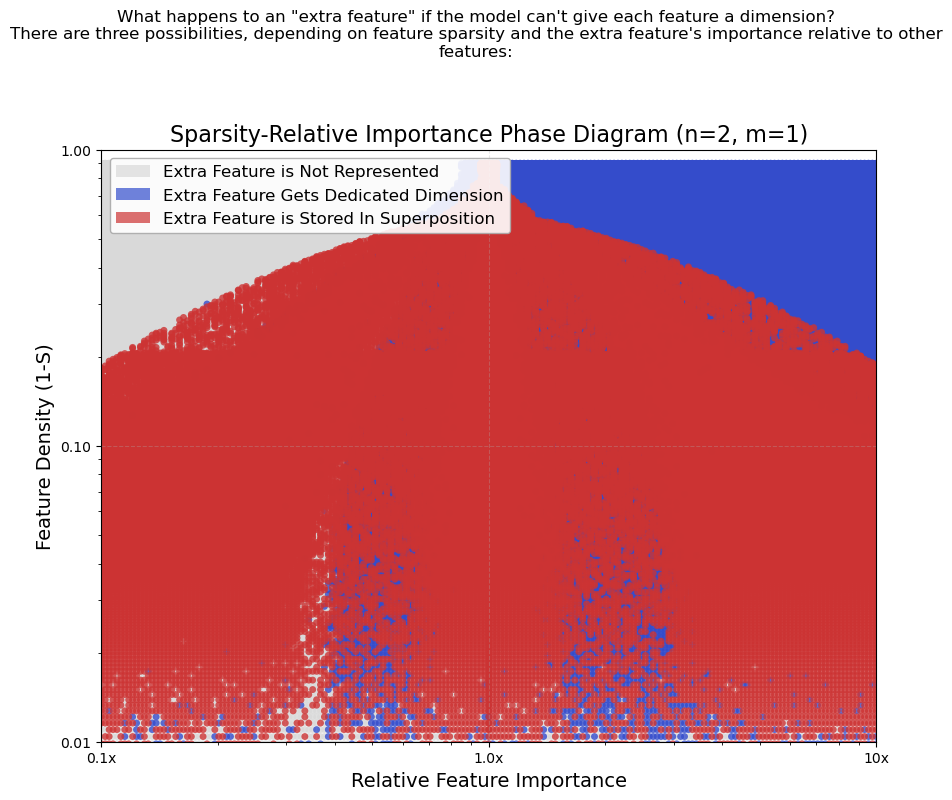

In [382]:
import matplotlib.ticker as ticker

def plot_superposition_phase_diagram(weights, sparsities, importances, from_numpy = True, save_path=None):
    """
    Create a phase diagram matching the reference image from the Toy Models of Superposition paper.
    
    Parameters:
    - weights: Tensor of shape [num_sweep^2, 2, 1] containing model weights
    - sparsities: Tensor of shape [num_sweep^2] containing sparsity values
    - importances: Tensor of shape [num_sweep^2, 2] containing importance values
    - save_path: Optional path to save the figure
    
    Returns:
    - Figure and axes objects
    """
    if not from_numpy:
        # Convert to numpy for plotting
        weights = weights.detach().cpu().numpy()
        sparsities = sparsities.detach().cpu().numpy()
        importances = importances.detach().cpu().numpy()
    
    # Calculate feature density and relative importance
    feature_density = 1 - sparsities
    relative_importance = importances[:, 1] / importances[:, 0]
    
    # Calculate metrics for phase determination
    feature1_weights = weights[:, 0, 0]
    feature2_weights = weights[:, 1, 0]
    
    # Calculate norms (absolute values in 1D case)
    feature1_norm = np.abs(feature1_weights)
    feature2_norm = np.abs(feature2_weights)
    
    # Calculate superposition metric (dot product squared)
    superposition = np.square(feature1_weights * feature2_weights)
    
    # Set up figure with specific dimensions to match reference
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Set thresholds for phase determination
    # These thresholds will need to be tuned based on your model's behavior
    feature_threshold = 0.1  # Threshold for feature being represented
    superposition_threshold = 0.1  # Threshold for superposition
    
    # Determine phases (0: not represented, 1: dedicated, 2: superposition)
    phase = np.zeros_like(feature_density)
    
    # Apply phase determination logic
    feature2_represented = feature2_norm > feature_threshold
    in_superposition = feature2_represented & (superposition > superposition_threshold)
    dedicated_dim = feature2_represented & ~in_superposition
    
    # Set phase values
    phase[dedicated_dim] = 1  # Blue - dedicated dimension
    phase[in_superposition] = 2  # Red - superposition
    
    # Sort indices to ensure proper rendering order (gray → blue → red)
    sort_idx = np.argsort(phase)
    
    # Create custom colormap that matches reference image
    colors = [
        (0.85, 0.85, 0.85),  # Light gray for "Not Represented"
        (0.2, 0.3, 0.8),     # Blue for "Dedicated Dimension"
        (0.8, 0.2, 0.2)      # Red for "Superposition"
    ]
    custom_cmap = LinearSegmentedColormap.from_list('toy_models_cmap', colors)
    
    # Plot the scatter points
    scatter = ax.scatter(
        relative_importance[sort_idx], 
        feature_density[sort_idx],
        c=phase[sort_idx], 
        cmap=custom_cmap, 
        s=25,  # Point size
        alpha=0.8,
        edgecolors='none'
    )
    
    # Configure axis scales and limits
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(0.1, 10)
    ax.set_ylim(0.01, 1.0)
    
    # Set specific tick positions to match reference
    ax.set_xticks([0.1, 1.0, 10])
    ax.set_xticklabels(['0.1x', '1.0x', '10x'])
    
    # Format y-ticks for consistent decimal places
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    
    # Add grid with specific style
    ax.grid(True, linestyle='--', alpha=0.3)
    
    # Set labels and title
    ax.set_title('Sparsity-Relative Importance Phase Diagram (n=2, m=1)', fontsize=16)
    ax.set_xlabel('Relative Feature Importance', fontsize=14)
    ax.set_ylabel('Feature Density (1-S)', fontsize=14)
    
    # # Add annotation text to match reference image
    # ax.text(0.5, 0.95, 
    #        "Each configuration is\ncolored by the norm\nand superposition of\nthe extra feature.",
    #        transform=ax.transAxes, ha='center', va='top', fontsize=12)
    
    # # Add formula annotation
    # ax.text(0.7, 0.4, r"$\sum_j (x_i \cdot x_j)^2$", 
    #         transform=ax.transAxes, fontsize=16)
    
    # # Add color scale annotation with levels
    # ax.text(0.7, 0.3, "0", transform=ax.transAxes, fontsize=12)
    # ax.text(0.75, 0.3, "≥1", transform=ax.transAxes, fontsize=12)
    
    # # Add horizontal line
    # ax.text(0.7, 0.25, "≥1", transform=ax.transAxes, fontsize=12)
    
    # # Add ||W_i|| annotation
    # ax.text(0.7, 0.15, r"$||W_i||$", transform=ax.transAxes, fontsize=16)
    
    # # Add final "0" annotation
    # ax.text(0.7, 0.1, "0", transform=ax.transAxes, fontsize=12)
    
    # Add legend with color boxes
    legend_elements = [
        plt.Rectangle((0, 0), 1, 1, fc=colors[0], alpha=0.7, 
                     label='Extra Feature is Not Represented'),
        plt.Rectangle((0, 0), 1, 1, fc=colors[1], alpha=0.7,
                     label='Extra Feature Gets Dedicated Dimension'),
        plt.Rectangle((0, 0), 1, 1, fc=colors[2], alpha=0.7,
                     label='Extra Feature is Stored In Superposition')
    ]
    
    ax.legend(handles=legend_elements, loc='upper left', fontsize=12, 
             framealpha=0.9, edgecolor='darkgray')
    
    # Add explanatory text at the top
    plt.figtext(0.5, 0.97, 
               "What happens to an \"extra feature\" if the model can't give each feature a dimension?\n"
               "There are three possibilities, depending on feature sparsity and the extra feature's importance relative to other features:",
               ha='center', fontsize=12, wrap=True)
    
    # Adjust layout
    # plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    
    # Save the figure if path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig, ax

plot_superposition_phase_diagram(Ws, sparsities, importances)